# KPOP tutorial

This tutorial is an introduction to the  KLIP POst Processing (KPOP) framework.
It includes the calculation of matched filter maps, SNR maps, detection, ROC curve and contrast curves calculation.

We show how to run a matched filter, SNR map calculation, detection of high SNR blobs and others.


## Preliminary

Execute the following lines before each other sections.
Depending on your system, the mkl module might be necessary.
Refer to http://pyklip.readthedocs.io/en/latest/install.html#note-on-parallelized-performance for use of mkl.

We have noticed that sometimes the notebook hangs probably because of the parallelization. In such a case, running the code in a normal python script should work.

In [1]:
try:
    import mkl
    mkl.set_num_threads(1)
except:
    print("Your code might run slowly.")
    print("/!\ Please Read http://pyklip.readthedocs.io/en/latest/install.html#note-on-parallelized-performance")
    
import os
import glob
import numpy as np
import pyklip.instruments.GPI as GPI
import pyklip.parallelized as parallelized

pykliproot = os.path.dirname(os.path.realpath(parallelized.__file__))
inputDir = os.path.join(pykliproot,"..","tests","data")
outputDir = inputDir

## Speckle subtraction
The matched filter should be performed on speckle subtracted dataset so let's reduce a test dataset with PyKlip using http://pyklip.readthedocs.io/en/latest/klip_gpi.html.
This step can be skipped if reduced images are already available. Read dataset and run speckle subtraction:

In [2]:
# Read the datacubes using the GPIData object
filelist = glob.glob(os.path.join(inputDir,"*spdc_distorcorr.fits"))
dataset = GPI.GPIData(filelist,highpass=True,meas_satspot_flux=False,numthreads=None)

parallelized.klip_dataset(dataset, outputdir=outputDir, fileprefix="bet_Pic_test",
                          annuli=9, subsections=4, movement=1, numbasis=[1,20,50,100],
                          calibrate_flux=True, mode="ADI+SDI")

Reading File: /home/sda/jruffio/pyklip/pyklip/../tests/data/S20131210S0111_spdc_distorcorr.fits
Reading File: /home/sda/jruffio/pyklip/pyklip/../tests/data/S20131210S0099_spdc_distorcorr.fits
Reading File: /home/sda/jruffio/pyklip/pyklip/../tests/data/S20131210S0092_spdc_distorcorr.fits
Beginning ADI+SDI KLIP
Begin align and scale images for each wavelength
Wavelength 1.157 with index 6 has finished align and scale. Queuing for KLIP
Wavelength 1.284 with index 26 has finished align and scale. Queuing for KLIP
Wavelength 1.297 with index 28 has finished align and scale. Queuing for KLIP
Wavelength 1.128 with index 1 has finished align and scale. Queuing for KLIP
Wavelength 1.291 with index 27 has finished align and scale. Queuing for KLIP
Wavelength 1.11 with index 0 has finished align and scale. Queuing for KLIP
Wavelength 1.263 with index 23 has finished align and scale. Queuing for KLIP
Wavelength 1.139 with index 3 has finished align and scale. Queuing for KLIP
Wavelength 1.151 with

/home/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


## Cross Correlation

The cross correlation is the most basic type of matched filter. It assumes that the noise is identically distributed for all the pixels in the image. See discussion in Ruffio et al. (2017).

The following shows different cases for applying the cross correlation.

### Single cube. Independent slices.

For example, pyklip produces fits cube where each slice is the a collapsed spectral cube but using different number of KL modes (filename suffix is KLmodes-all). calculate_cc() will process each slice independently if a cube of data is given instead.

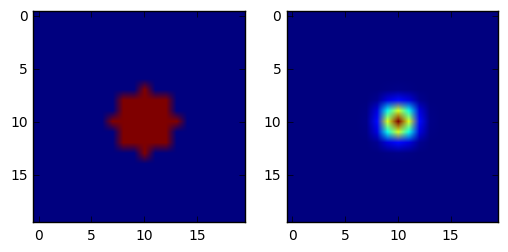

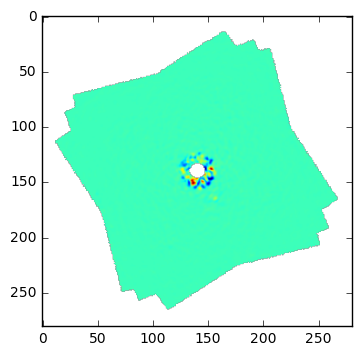

In [3]:
from pyklip.kpp.metrics.crossCorr import calculate_cc
import astropy.io.fits as pyfits

# Definition of the cross correlation object
filename = os.path.join(outputDir,"bet_Pic_test-KLmodes-all.fits")
hdulist = pyfits.open(filename)
cube = hdulist[1].data
prihdr = hdulist[0].header
exthdr = hdulist[1].header
hdulist.close()

from pyklip.kpp.utils.mathfunc import *
x_grid,y_grid= np.meshgrid(np.arange(-10,10),np.arange(-10,10))

# Definition of the PSF
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(1)
plt.subplot(1,2,1)
plt.imshow(hat(x_grid,y_grid, radius=3))
plt.subplot(1,2,2)
plt.imshow(gauss2d(x_grid,y_grid, amplitude = 1.0, xo = 0.0, yo = 0.0, sigma_x = 1.0, sigma_y = 1.0))


PSF = gauss2d(x_grid,y_grid, amplitude = 1.0, xo = 0.0, yo = 0.0, sigma_x = 1.0, sigma_y = 1.0)
cube_cc = calculate_cc(cube, PSF,spectrum = None, nans2zero=True)

import matplotlib.pyplot as plt
plt.figure(2)
plt.imshow(cube_cc[2,::-1,:])

### Single Spectral Cube

For example, pyklip produces spectral cube with the suffix "speccube". calculate_cc can first collapse the cube with a given spectrum before running the cross correlation using the keyword "spectrum". Here we are using the atmospheric models from Marley et al. (2017, in prep.) and Saumon et al. 2012.

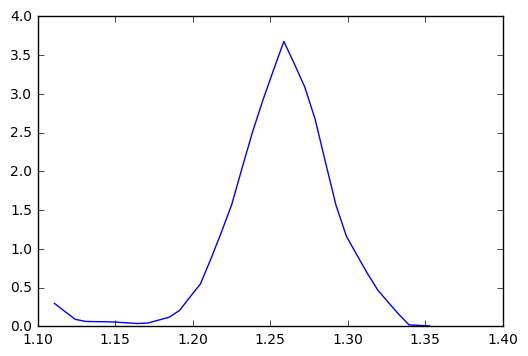

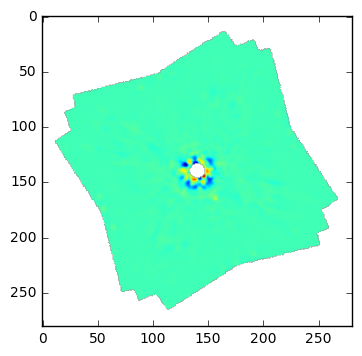

In [4]:
from pyklip.kpp.metrics.crossCorr import calculate_cc
import astropy.io.fits as pyfits

# Definition of the cross correlation object
filename = os.path.join(outputDir,"bet_Pic_test-KLmodes-all.fits")
hdulist = pyfits.open(filename)
cube = hdulist[1].data
prihdr = hdulist[0].header
exthdr = hdulist[1].header
hdulist.close()

# Definition of the planet spectrum (not corrected )
import pyklip.instruments.GPI as GPI
import pyklip.spectra_management as spec
from glob import glob
pykliproot = os.path.dirname(os.path.realpath(spec.__file__))
reduc_spectrum = "t600g100nc" # sharp methane feature
spectrum_filename = os.path.abspath(glob(os.path.join(pykliproot,"spectra","*",reduc_spectrum+".flx"))[0])
# Interpolate the spectrum of the planet based on the given filename
wv,planet_sp = spec.get_planet_spectrum(spectrum_filename,GPI.get_gpi_wavelength_sampling("J"))

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(wv,planet_sp)

# Definition of the PSF
from pyklip.kpp.utils.mathfunc import *
x_grid,y_grid= np.meshgrid(np.arange(-10,10),np.arange(-10,10))
PSF = gauss2d(x_grid,y_grid, amplitude = 1.0, xo = 0.0, yo = 0.0, sigma_x = 1.0, sigma_y = 1.0)


image_cc = calculate_cc(cube, PSF,spectrum = planet_sp, nans2zero=True)

import matplotlib.pyplot as plt
plt.figure(2)
plt.imshow(image_cc[::-1,:])


### SNR calculation

get_image_stat() can be used to estimate the SNR map. It estimate the standard deviation in concentric annuli at each separation.
To avoid self-contamination of a real planet signal, get_image_stat_map_perPixMasking() can be used. It estimates the standard deviation for each pixel independently by masking its surroundings before calculating the standard deviation in an annulus at the same separation.

/home/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


The SNR peak in the image is 10.69 sigma.
The SNR peak in the image is 20.23 sigma.


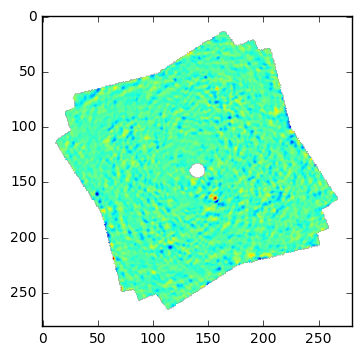

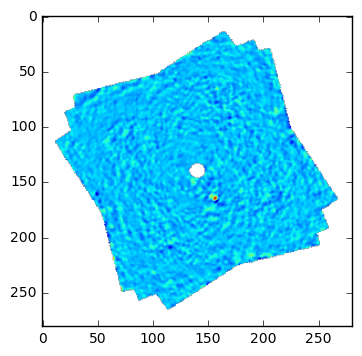

In [5]:
from pyklip.kpp.stat.statPerPix_utils import get_image_stat_map_perPixMasking
from pyklip.kpp.stat.stat_utils import get_image_stat_map
from pyklip.kpp.metrics.crossCorr import calculate_cc
import astropy.io.fits as pyfits

# Definition of the cross correlation object
filename = os.path.join(outputDir,"bet_Pic_test-KLmodes-all.fits")
hdulist = pyfits.open(filename)
cube = hdulist[1].data
prihdr = hdulist[0].header
exthdr = hdulist[1].header
center = [exthdr['PSFCENTX'], exthdr['PSFCENTY']]
hdulist.close()

# Definition of the PSF
from pyklip.kpp.utils.mathfunc import *
x_grid,y_grid= np.meshgrid(np.arange(-10,10),np.arange(-10,10))
PSF = gauss2d(x_grid,y_grid, amplitude = 1.0, xo = 0.0, yo = 0.0, sigma_x = 1.0, sigma_y = 1.0)
# Run cross correlation first
image_cc = calculate_cc(cube[2,:,:], PSF,spectrum = None, nans2zero=True)

%matplotlib inline
import matplotlib.pyplot as plt
SNR_map = get_image_stat_map(image_cc,
                           centroid = center,
                           r_step=2,
                           Dr = 2,
                           type = "SNR")
plt.figure(1)
print("The SNR peak in the image is {0:.2f} sigma.".format(np.nanmax(SNR_map)))
plt.imshow(SNR_map[::-1,:])

SNR_map = get_image_stat_map_perPixMasking(image_cc,
                                           centroid = center,
                                           mask_radius=5,
                                           Dr = 2,
                                           type = "SNR")
plt.figure(2)
print("The SNR peak in the image is {0:.2f} sigma.".format(np.nanmax(SNR_map)))
plt.imshow(SNR_map[::-1,:])

## Matched Filter

Here, we make a difference between matched filter and cross correlation. The cross correlation doesn't account for noise variation in the image while the matched filter does. There is a normalization by the local standard deviation, which is estimated from the image/cube directly. See discussion in Ruffio et al. (2017).

We show an example with a GPI spectral klipped datacube.

### Single Spectral Cube

The SNR peak in the image is 22.51 sigma.


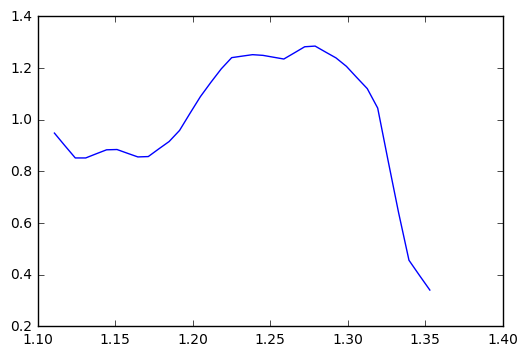

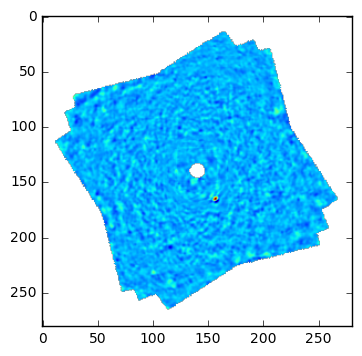

In [6]:
from pyklip.kpp.metrics.matchedfilter import run_matchedfilter
from pyklip.kpp.metrics.crossCorr import calculate_cc
from pyklip.kpp.stat.statPerPix_utils import get_image_stat_map_perPixMasking
import astropy.io.fits as pyfits

# Definition of the cross correlation object
filename = os.path.join(outputDir,"bet_Pic_test-KL20-speccube.fits")
hdulist = pyfits.open(filename)
cube = hdulist[1].data
prihdr = hdulist[0].header
exthdr = hdulist[1].header
center = [exthdr['PSFCENTX'], exthdr['PSFCENTY']]
nl,ny,nx = cube.shape
hdulist.close()

# Definition of the planet spectrum (not corrected )
import pyklip.instruments.GPI as GPI
import pyklip.spectra_management as spec
from glob import glob
pykliproot = os.path.dirname(os.path.realpath(spec.__file__))
reduc_spectrum = "t1300g100f2" # L-type
spectrum_filename = os.path.abspath(glob(os.path.join(pykliproot,"spectra","*",reduc_spectrum+".flx"))[0])
# Interpolate the spectrum of the planet based on the given filename
wv,planet_sp = spec.get_planet_spectrum(spectrum_filename,GPI.get_gpi_wavelength_sampling("J"))

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(wv,planet_sp)

# Definition of the PSF
from pyklip.kpp.utils.mathfunc import *
x_grid,y_grid= np.meshgrid(np.arange(-10,10),np.arange(-10,10))
PSF = gauss2d(x_grid,y_grid, amplitude = 1.0, xo = 0.0, yo = 0.0, sigma_x = 1.0, sigma_y = 1.0)
PSF = np.tile(PSF,(nl,1,1))*planet_sp[:,None,None]

mf_map,cc_map,flux_map = run_matchedfilter(cube, PSF,N_threads=None,maskedge=True)

SNR_map = get_image_stat_map_perPixMasking(mf_map,
                                           centroid = center,
                                           mask_radius=5,
                                           Dr = 2,
                                           type = "SNR")
plt.figure(2)
print("The SNR peak in the image is {0:.2f} sigma.".format(np.nanmax(SNR_map)))
plt.imshow(SNR_map[::-1,:])

## Planet Detection

The detection steps simply consists in spotting the brighter blobs in a SNR maps. The Detection class generate a table saved a .csv file with an order list of these blobs with their SNR and position.

Make sure the image "SNR_map" is defined by executed one of the previous cells.

In [9]:
import csv
from pyklip.kpp.detection.detection import point_source_detection
# list of the local maxima with their info
#         Description by column: ["index","value","PA","Sep (pix)","Sep (as)","x","y","row","col"]
#         1/ index of the candidate
#         2/ Value of the maximum
#         3/ Position angle in degree from North in [0,360]
#         4/ Separation in pixel
#         5/ Separation in arcsec
#         6/ x position in pixel
#         7/ y position in pixel
#         8/ row index
#         9/ column index
detec_threshold = 3
pix2as = 0.014166
candidates_table = point_source_detection(SNR_map, center,detec_threshold,pix2as=pix2as,
                                         mask_radius = 15,maskout_edge=10,IWA=None, OWA=None)
print(candidates_table)
savedetections = os.path.join(outputDir,"detections.csv")
with open(savedetections, 'w+') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=';')
    csvwriter.writerows([["index","value","PA","Sep (pix)","Sep (as)","x","y","row","col"]])
    csvwriter.writerows(candidates_table)

[[1, 22.507270666361865, 211.60750224624888, 30.528675044947494, 0.43246921068672622, 16.0, -26.0, 114, 156], [2, 5.7770573067307609, 156.50143432404792, 100.31948963187563, 1.42112589012515, -40.0, -92.0, 48, 100], [3, 5.1664945707366847, 219.57940471623763, 97.308786859152647, 1.3784762746467565, 62.0, -75.0, 65, 202], [4, 4.5326096260277975, 122.66091272167381, 92.649878575203758, 1.3124781798963363, -78.0, -50.0, 90, 62], [5, 4.5257877975776823, 57.264773727892404, 99.859901862559425, 1.4146153697850168, -84.0, 54.0, 194, 56], [6, 4.4143363198497738, 105.68999292908387, 92.444577991356525, 1.3095698918255565, -89.0, -25.0, 115, 51], [7, 4.2401189057586981, 171.86989764584402, 7.0710678118654755, 0.10016874662288633, -1.0, -7.0, 133, 139], [8, 4.2098632481873057, 147.56346939851838, 126.77933585565118, 1.7959560717311547, -68.0, -107.0, 33, 72], [9, 4.0901073419229386, 90.0, 19.0, 0.269154, -19.0, 0.0, 140, 121], [10, 4.0767096388596356, 165.96375653207352, 103.07764064044152, 1.460

Plot the detected blobs:

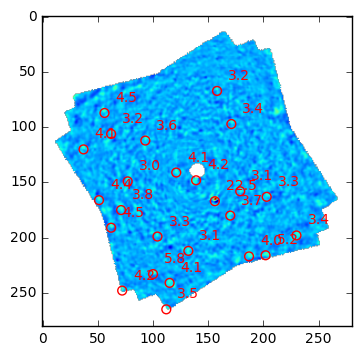

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(SNR_map[::-1,:])

with open(savedetections, 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    csv_as_list = list(reader)
    detec_table_labels = csv_as_list[0]
    detec_table = np.array(csv_as_list[1::], dtype='string').astype(float)

metric_id = detec_table_labels.index("value")
row_id = detec_table_labels.index("row")
col_id = detec_table_labels.index("col")

ax = plt.gca()
ny,nx = SNR_map.shape
for snr,row,col in zip(detec_table[:,metric_id],detec_table[:,row_id],detec_table[:,col_id]):
    circle=plt.Circle((col,ny-row),radius=4.,color='r',fill=False)
    ax.add_artist(circle)
    ax.annotate("{0:.1f}".format(snr), fontsize=10, color = "red",xy=(col,ny-row),
                xycoords='data', xytext=(col+10, ny-row-10))